In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df0 = pd.read_csv("/content/spotify_songs_dataset.csv")
df = df0.copy()

In [3]:
df.sample(n=10)

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer,collaboration
12752,SP12753,Project collection.,Robert Lang,Service spring.,Folk,2007-05-13,209.0,46,80684799,English,Yes,Universal Music,Elizabeth Johnson,Jessica Reese,NaN
25658,SP25659,Few late.,Kimberly Perez,Per word.,Hip-Hop,2018-08-18,NaN,20,85338806,English,No,Warner Music,Matthew Smith,Stephanie Palmer,NaN
28360,SP28361,Sign short specific thought.,Michelle Alvarez,Foreign turn.,Pop,2016-10-16,199.0,45,50201228,English,Yes,Universal Music,Bryan Conway,Rhonda Miller,Charles Martin
29659,SP29660,Nature edge.,Jeremy Brown,Dream.,Hip-Hop,2001-06-23,214.0,5,72913564,English,Yes,Universal Music,Derek Reeves,John Johns,NaN
30353,SP30354,Edge enter minute.,Christina Crosby,Out land.,R&B,2019-12-21,233.0,84,99117122,Spanish,Yes,Universal Music,Kendra Barnes,Melissa Welch,NaN
12633,SP12634,Military.,Neil Hobbs,Cultural computer.,Pop,1998-10-21,NaN,1,98612140,English,Yes,Atlantic Records,Marcus Austin,Kelly Williams,Curtis Wood
4144,SP4145,Old war Republican.,Meredith Espinoza,Alone like.,Hip-Hop,1995-03-17,216.0,42,44659193,Spanish,No,Atlantic Records,Michael Nguyen,Brenda May,NaN
32097,SP32098,Cold within marriage.,Mrs. Rachel Deleon DDS,Field her.,Electronic,2001-08-26,178.0,9,76858898,Italian,No,Sony Music,Kathy Burnett,Lisa Schroeder,NaN
40563,SP40564,South city rule people.,Karen Sims,Into.,Classical,2008-03-26,NaN,81,73778022,English,No,Indie,Charles Skinner,Danielle Rodriguez,NaN
13915,SP13916,Consumer question.,Alicia Wong,Woman day.,Hip-Hop,2006-03-13,208.0,14,49125386,English,Yes,Atlantic Records,Sharon Campbell,Ray Mcintyre,Bradley Dean


In [4]:
df.shape

(50000, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           50000 non-null  object 
 1   song_title        50000 non-null  object 
 2   artist            50000 non-null  object 
 3   album             50000 non-null  object 
 4   genre             50000 non-null  object 
 5   release_date      50000 non-null  object 
 6   duration          45000 non-null  float64
 7   popularity        50000 non-null  int64  
 8   stream            50000 non-null  int64  
 9   language          47500 non-null  object 
 10  explicit_content  50000 non-null  object 
 11  label             50000 non-null  object 
 12  composer          50000 non-null  object 
 13  producer          50000 non-null  object 
 14  collaboration     15000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 5.7+ MB


In [6]:
df.duplicated().sum()

np.int64(0)

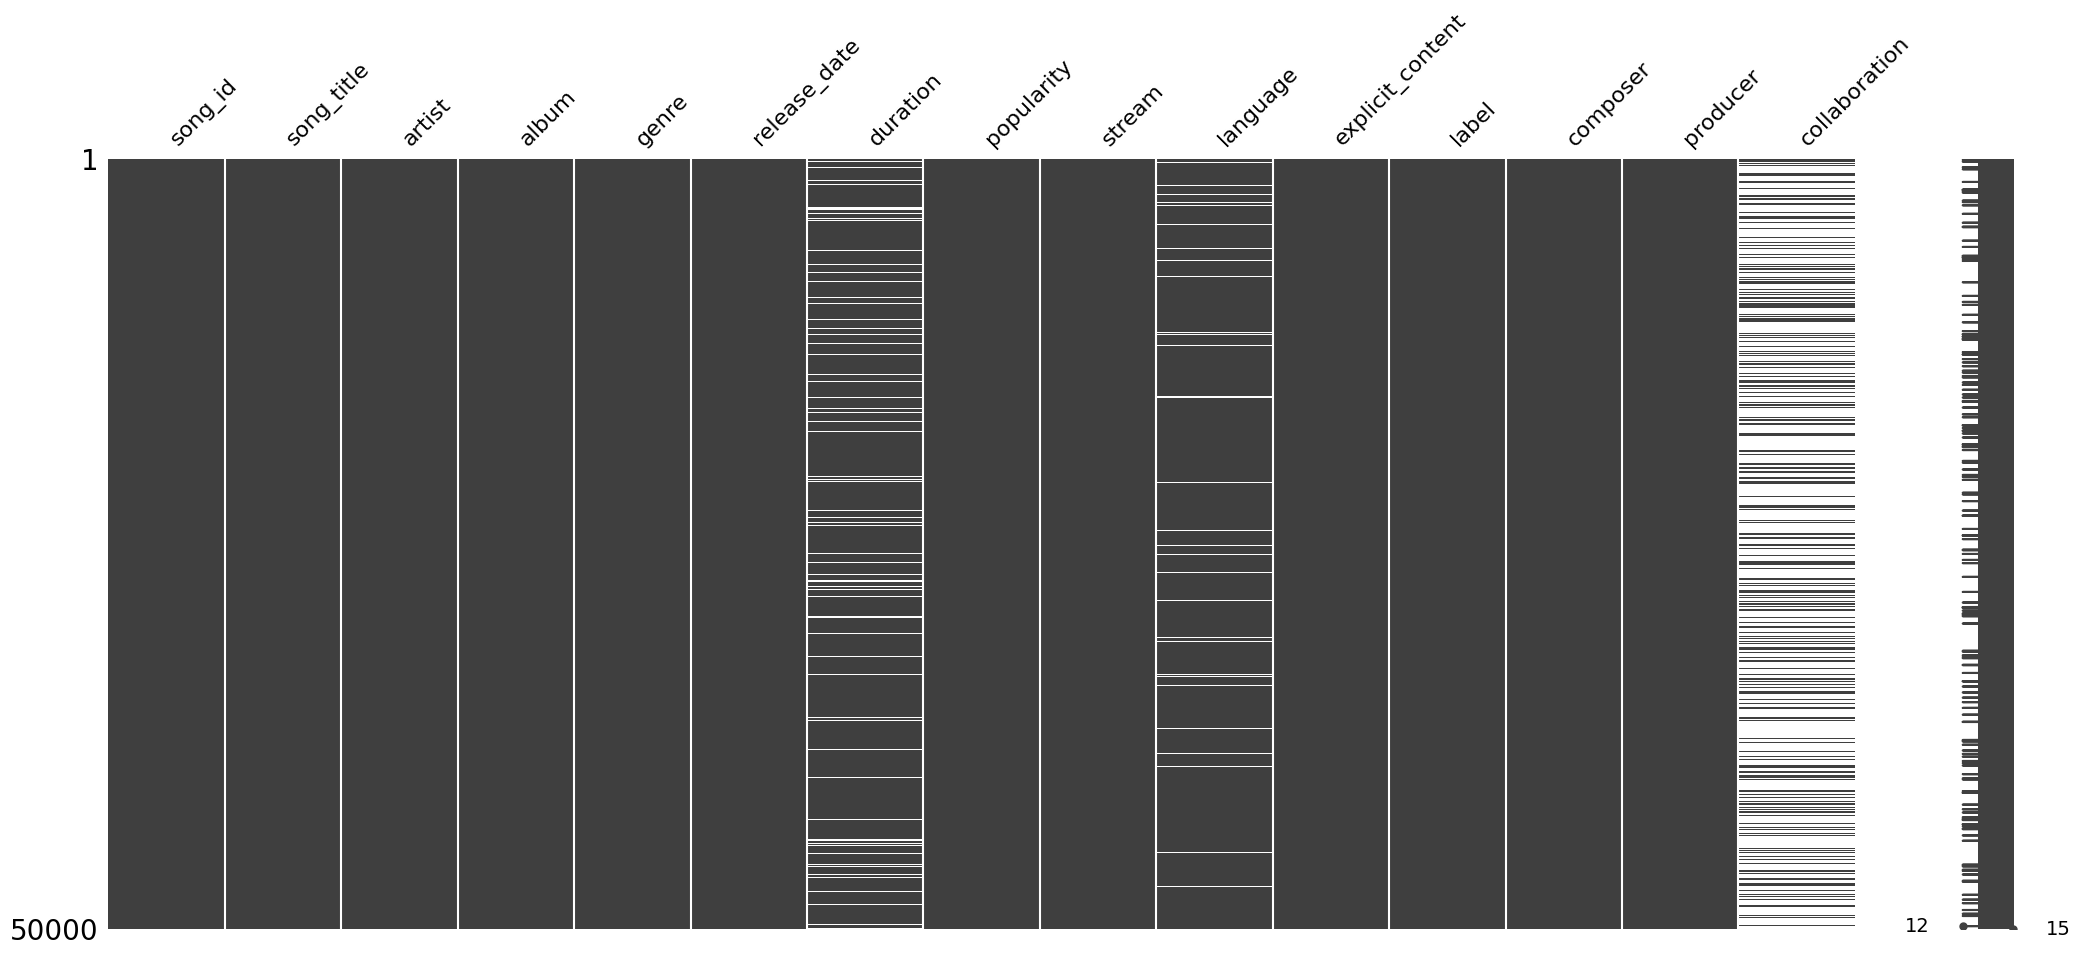

In [7]:
msno.matrix(df);

In [8]:
df["song_title"] = df["song_title"].str.title()
df.song_title.nunique()

46396

In [9]:
df["album"] = df["album"].str.title()

In [10]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

max_year = df['release_date'].dt.year.max()

print(f"O maior ano: {max_year}")

O maior ano: 2024


In [11]:
min_year = df['release_date'].dt.year.min()
print(f"O menor ano é: {min_year}")

O menor ano é: 1994


In [12]:
df.groupby("genre")["duration"].mean().round(0)

,duration
genre,
Classical,239.0
Country,239.0
Electronic,240.0
Folk,240.0
Hip-Hop,240.0
Jazz,240.0
Pop,239.0
R&B,240.0
Reggae,241.0


In [13]:
df['duration'] = df.groupby('genre')['duration'].apply(lambda x: x.fillna(x.mean().round(0))).reset_index(level=0, drop=True)

In [14]:
df['language'] = df.groupby('genre')['language'].apply(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
).reset_index(level=0, drop=True)

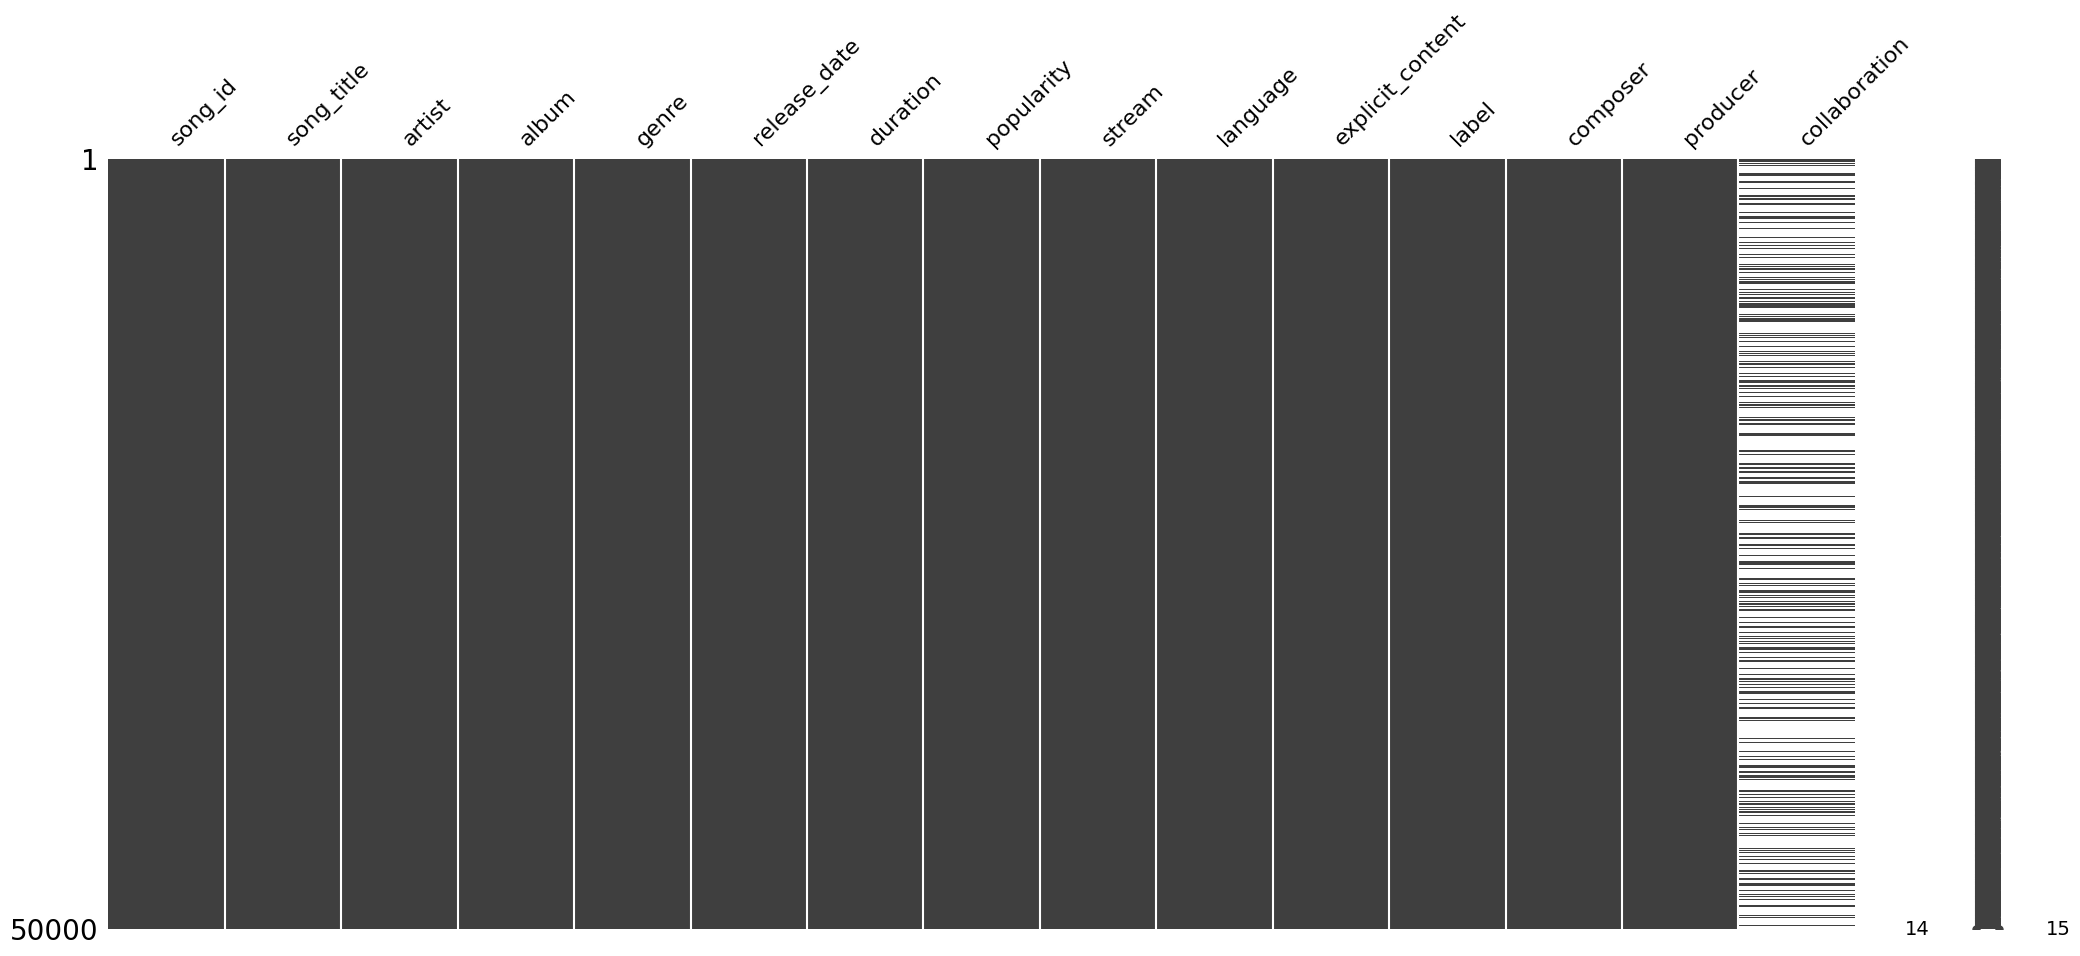

In [15]:
msno.matrix(df);

In [16]:
df.collaboration.isnull().sum()

np.int64(35000)

In [17]:
df = df.drop('collaboration', axis=1)
df.head()

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer
0,SP0001,Space Executive Series.,Sydney Clark,What.,Electronic,1997-11-08,282.0,42,35055874,English,Yes,Def Jam,Amy Hatfield,Jeffrey Weaver
1,SP0002,Price Last Painting.,Connor Peters DDS,Nature Politics.,Electronic,2015-05-10,127.0,50,9249527,English,Yes,Universal Music,Jason Gregory,Kenneth White
2,SP0003,Piece.,Anna Keith,Visit.,Pop,2024-07-08,239.0,10,76669110,English,Yes,Universal Music,Rachel Lopez,Jason Barnes
3,SP0004,Power Industry Your.,Zachary Simpson,Behavior Evening.,Hip-Hop,2022-08-15,214.0,86,34732016,English,No,Sony Music,Thomas Li,Mrs. Becky Palmer
4,SP0005,Food Animal Second.,Christopher Mcgee,Front.,Pop,2023-03-05,273.0,63,96649372,English,Yes,Def Jam,Adam Wagner,Beverly Baker


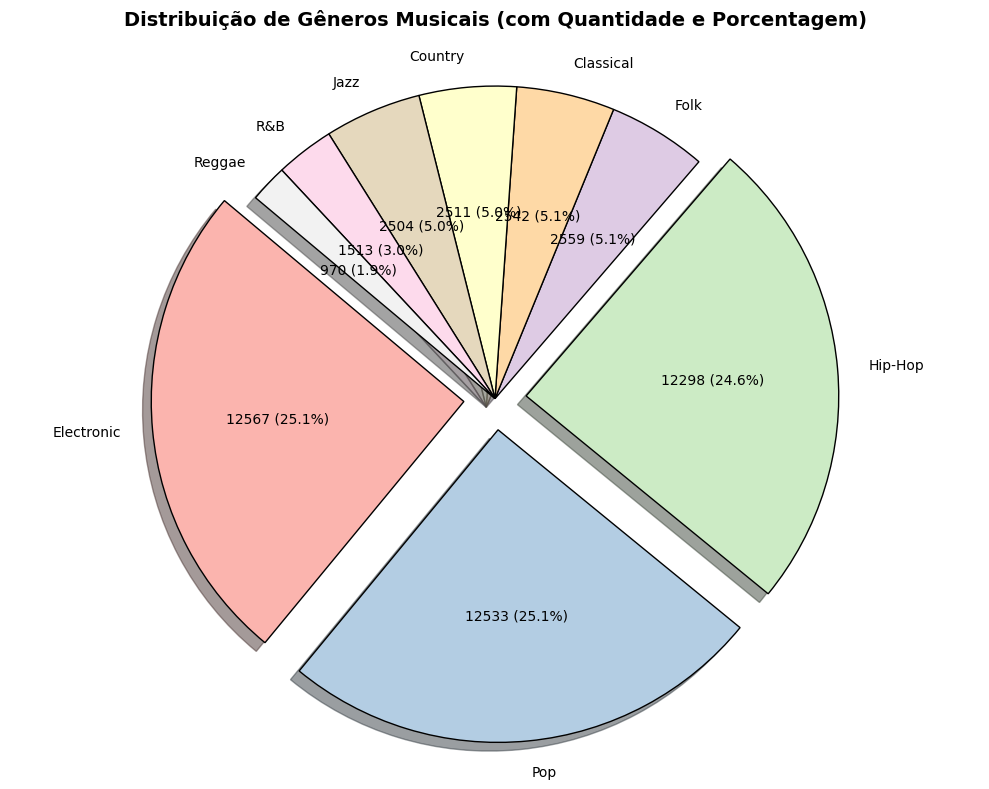

In [18]:
genre_counts = df['genre'].value_counts()
labels = genre_counts.index
sizes = genre_counts.values

colors = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))

explode = [0.1 if i < 3 else 0 for i in range(len(labels))]

plt.figure(figsize=(10, 8))

patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: f'{int(pct/100.*np.sum(sizes))} ({pct:.1f}%)',
    colors=colors,
    shadow=True,
    startangle=140,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.title('Distribuição de Gêneros Musicais (com Quantidade e Porcentagem)', fontsize=14, weight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

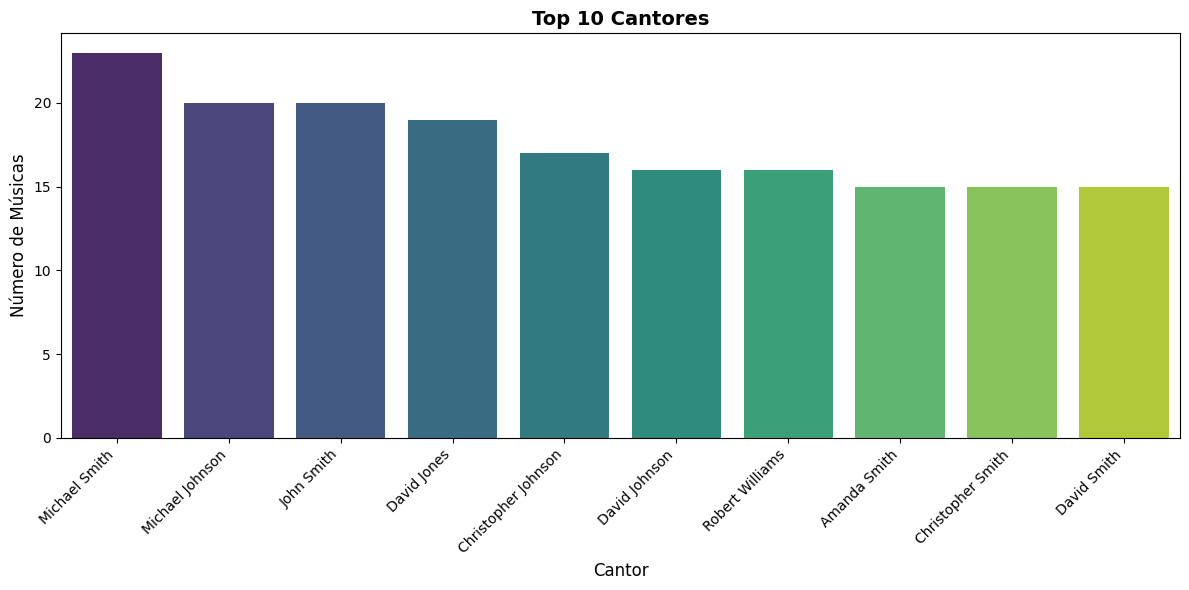

In [19]:
top_10_artists = df['artist'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_artists.index, y=top_10_artists.values, palette='viridis')
plt.title('Top 10 Cantores', fontsize=14, weight='bold')
plt.xlabel('Cantor', fontsize=12)
plt.ylabel('Número de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

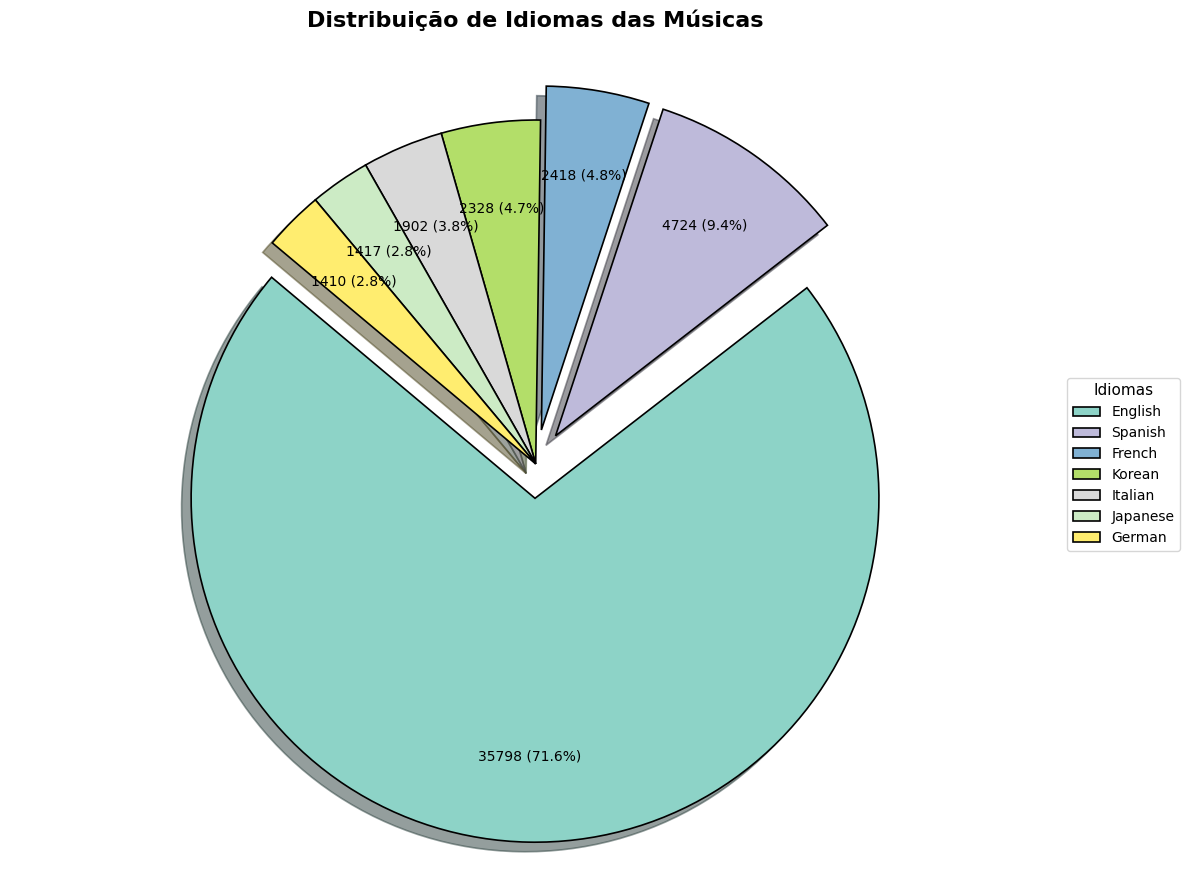

In [20]:
language_counts = df['language'].value_counts()
labels_lang = language_counts.index
sizes_lang = language_counts.values

colors_lang = plt.cm.Set3(np.linspace(0, 1, len(labels_lang)))

explode_lang = [0.1 if i < 3 else 0 for i in range(len(labels_lang))]

plt.figure(figsize=(12, 9))

def custom_autopct(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f'{absolute} ({pct:.1f}%)' if pct > 2 else ''

patches_lang, texts_lang, autotexts_lang = plt.pie(
    sizes_lang,
    labels=None,
    autopct=lambda pct: custom_autopct(pct, sizes_lang),
    colors=colors_lang,
    shadow=True,
    startangle=140,
    explode=explode_lang,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.2},
    pctdistance=0.75
)

for autotext in autotexts_lang:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.legend(
    patches_lang,
    labels_lang,
    title="Idiomas",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.title('Distribuição de Idiomas das Músicas', fontsize=16, weight='bold', pad=15)
plt.axis('equal')
plt.tight_layout()
plt.show()


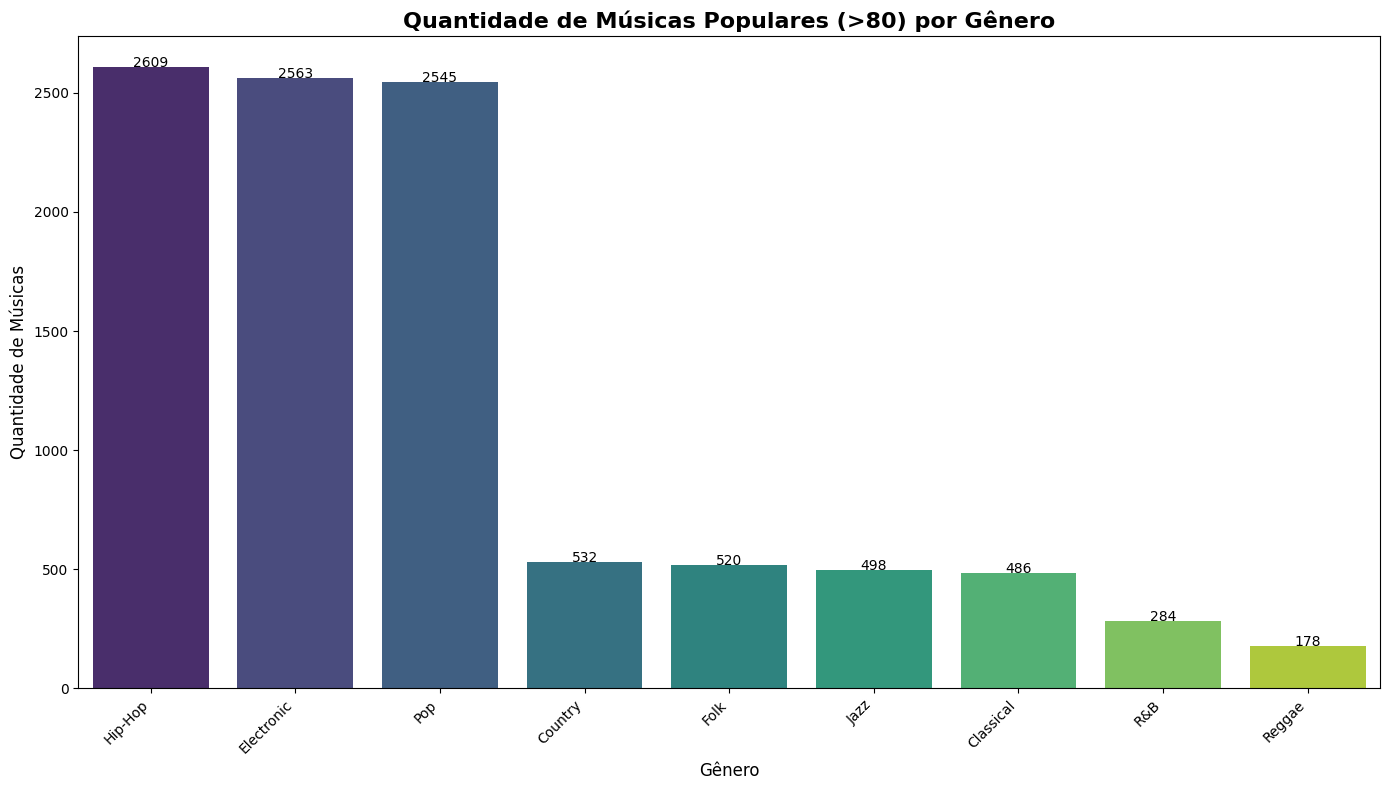

In [21]:
df_popular = df[df['popularity'] > 80]

genre_counts_popular = df_popular['genre'].value_counts().reset_index()
genre_counts_popular.columns = ['genre', 'count']

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='genre', y='count', data=genre_counts_popular, palette='viridis')

for index, row in genre_counts_popular.iterrows():
    barplot.text(index, row['count'], row['count'], color='black', ha="center")

plt.title('Quantidade de Músicas Populares (>80) por Gênero', fontsize=16, weight='bold')
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Quantidade de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


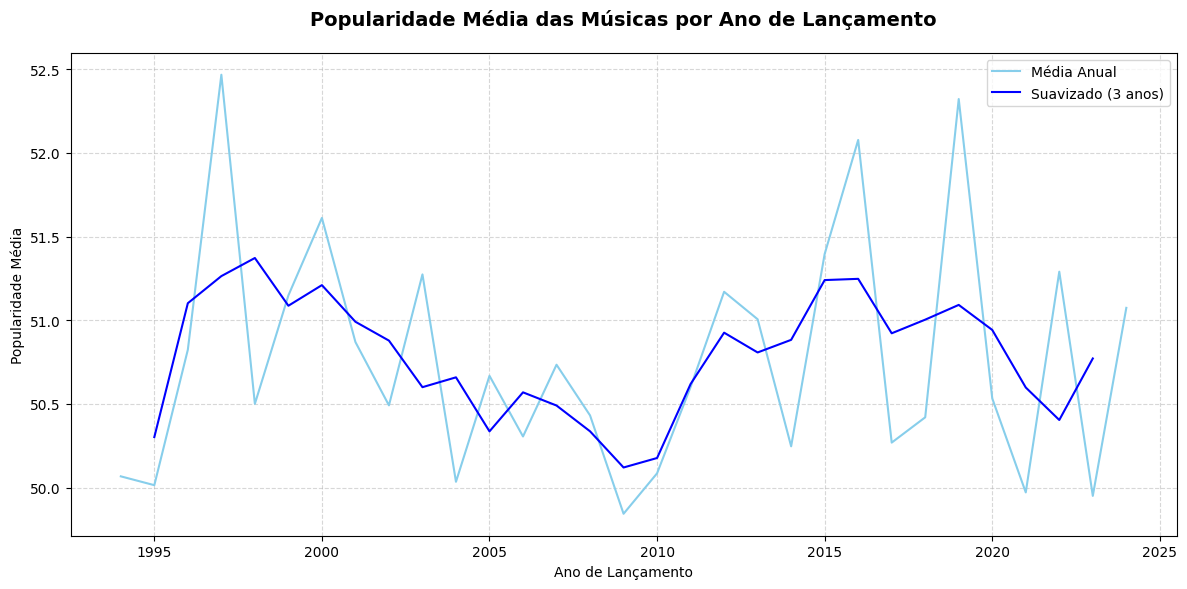

In [22]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_year'] = df['release_date'].dt.year

df_yearly = df[df['release_year'].between(1950, 2025)]

yearly_popularity = df_yearly.groupby('release_year')['popularity'].mean().reset_index()

yearly_popularity['popularity_smooth'] = yearly_popularity['popularity'].rolling(window=3, center=True).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x='release_year', y='popularity', data=yearly_popularity, label='Média Anual', color='skyblue')
sns.lineplot(x='release_year', y='popularity_smooth', data=yearly_popularity, label='Suavizado (3 anos)', color='blue')

plt.title('Popularidade Média das Músicas por Ano de Lançamento', fontsize=14, weight='bold', pad=20)
plt.xlabel('Ano de Lançamento')
plt.ylabel('Popularidade Média')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Top 10 Álbuns por Stream:
                 album              artist     stream
44851           Today.     Robert Williams  177448826
48051           While.        Thomas Davis  148377336
12024           Dream.        Joshua Smith  116527102
22541            Late.       Michael Brown  112238234
29821             Our.       Michael Clark  100385797
38644         Similar.  Catherine Anderson   99999128
5175          Billion.        Selena Perez   99998468
2570   Appear Trouble.        Thomas Roach   99996451
44229      Those Task.    Jason Strickland   99993859
12285     Each Season.      Monica Stevens   99992156


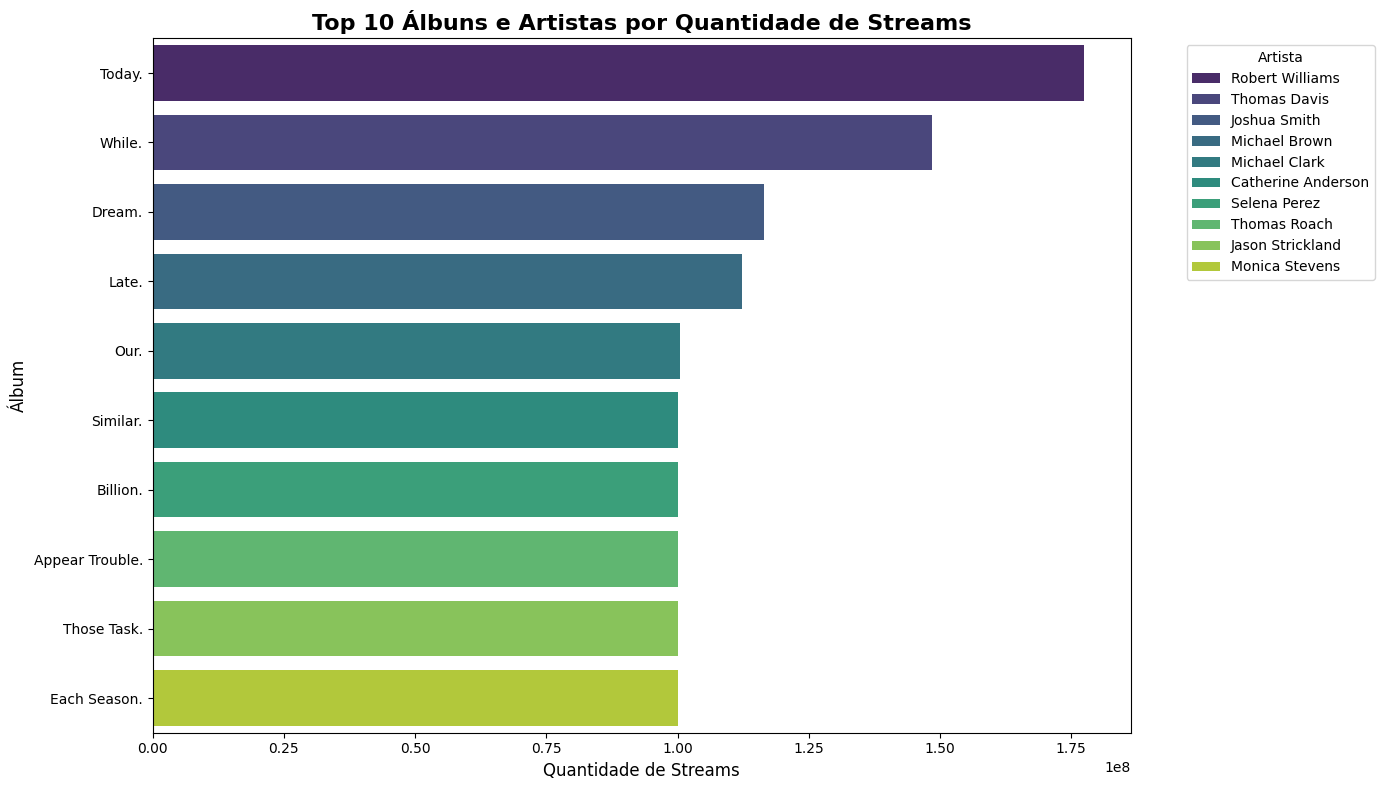

In [23]:
album_streams = df.groupby(['album', 'artist'])['stream'].sum().reset_index()

top_10_albums_by_streams = album_streams.sort_values(by='stream', ascending=False).head(10)

print("Top 10 Álbuns por Stream:")
print(top_10_albums_by_streams)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_10_albums_by_streams,
    x='stream',
    y='album',
    hue='artist',
    dodge=False,
    palette='viridis'
)

plt.title('Top 10 Álbuns e Artistas por Quantidade de Streams', fontsize=16, weight='bold')
plt.xlabel('Quantidade de Streams', fontsize=12)
plt.ylabel('Álbum', fontsize=12)
plt.legend(title='Artista', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


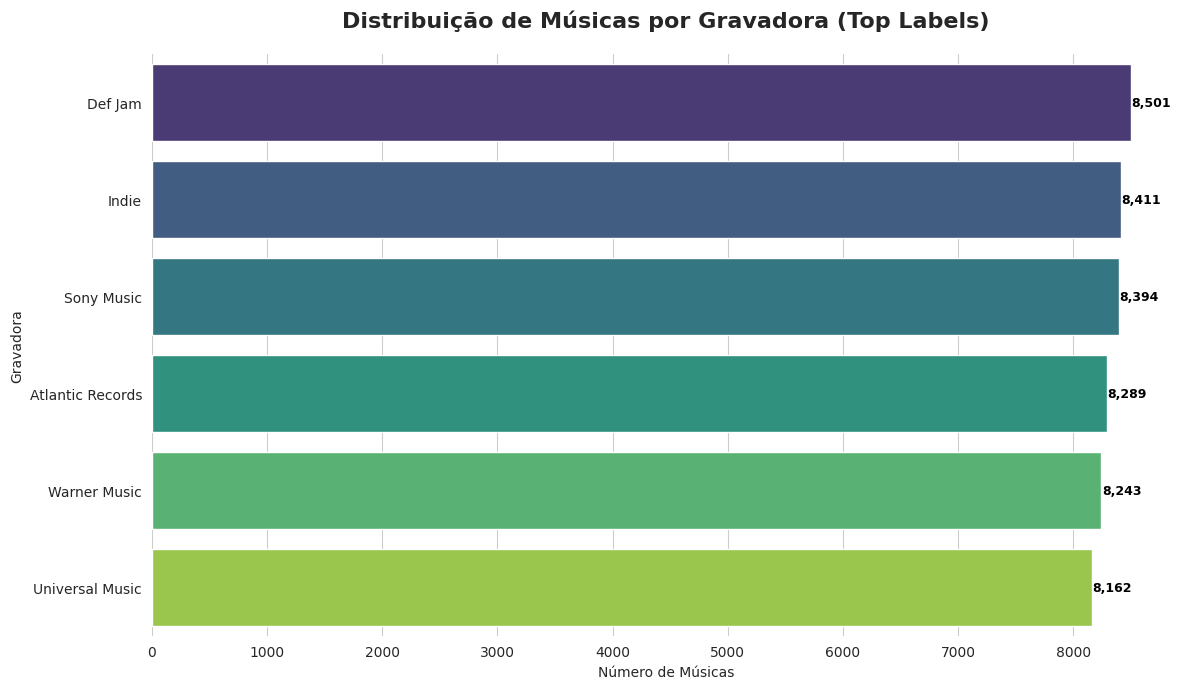

In [24]:
label_count = df.label.value_counts()
label_count_sorted = label_count.sort_values(ascending=False)[:15]

colors = sns.color_palette("viridis", len(label_count_sorted))

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=label_count_sorted.values,
    y=label_count_sorted.index,
    palette=colors
)

for i, v in enumerate(label_count_sorted.values):
    ax.text(v + 5, i, f'{v:,}', color='black', va='center', fontsize=9, weight='bold')

plt.title('Distribuição de Músicas por Gravadora (Top Labels)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Número de Músicas')
plt.ylabel('Gravadora')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [25]:
df['release_date'] = pd.to_datetime(df['release_date'])

            popularity        stream  count
genre                                      
Country      51.661888  5.046560e+07   2511
Folk         51.467370  5.048961e+07   2559
Hip-Hop      50.918117  5.021347e+07  12298
Electronic   50.853517  5.021413e+07  12568
Pop          50.684059  4.991478e+07  12534
Jazz         50.431310  4.969095e+07   2504
R&B          50.335096  5.097805e+07   1513
Reggae       49.954686  5.141851e+07    971
Classical    49.649489  5.032964e+07   2542


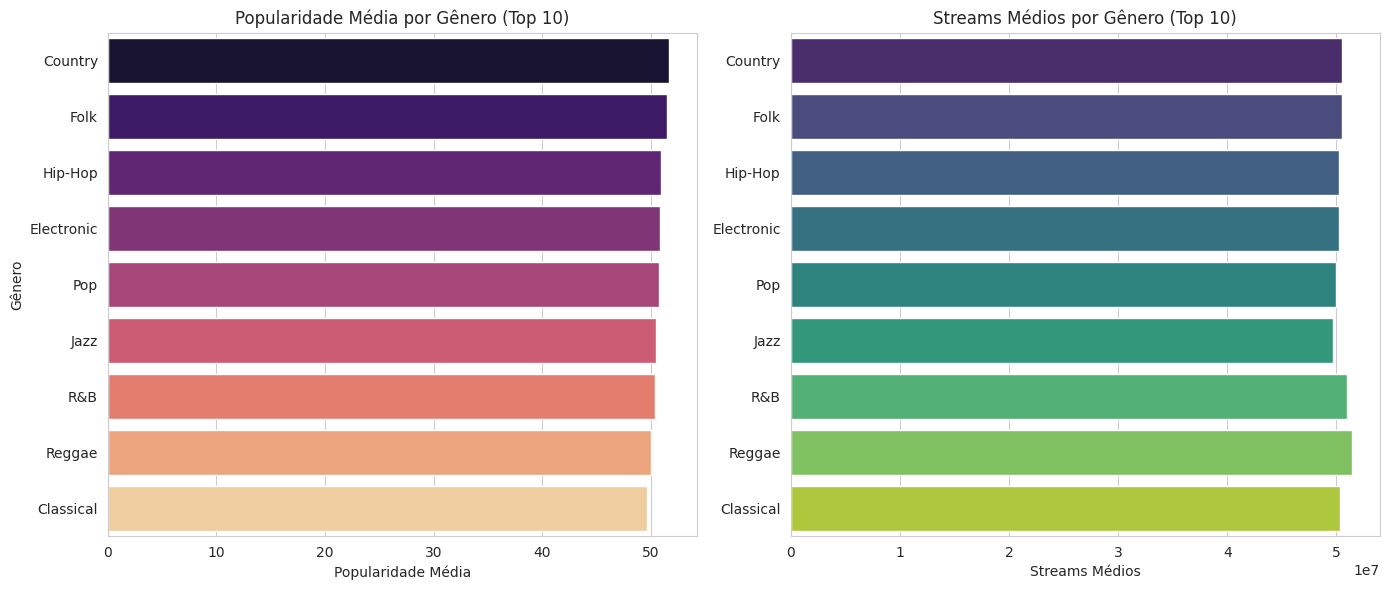

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_stats = df.groupby('genre').agg({
    'popularity': 'mean',
    'stream': 'mean',
    'song_id': 'count'
}).rename(columns={'song_id': 'count'}).sort_values(by='popularity', ascending=False)

print(genre_stats.head(10))

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(x=genre_stats.head(10).popularity, y=genre_stats.head(10).index, palette='magma')
plt.title('Popularidade Média por Gênero (Top 10)')
plt.xlabel('Popularidade Média')
plt.ylabel('Gênero')

plt.subplot(1,2,2)
sns.barplot(x=genre_stats.head(10).stream, y=genre_stats.head(10).index, palette='viridis')
plt.title('Streams Médios por Gênero (Top 10)')
plt.xlabel('Streams Médios')
plt.ylabel('')

plt.tight_layout()
plt.show()


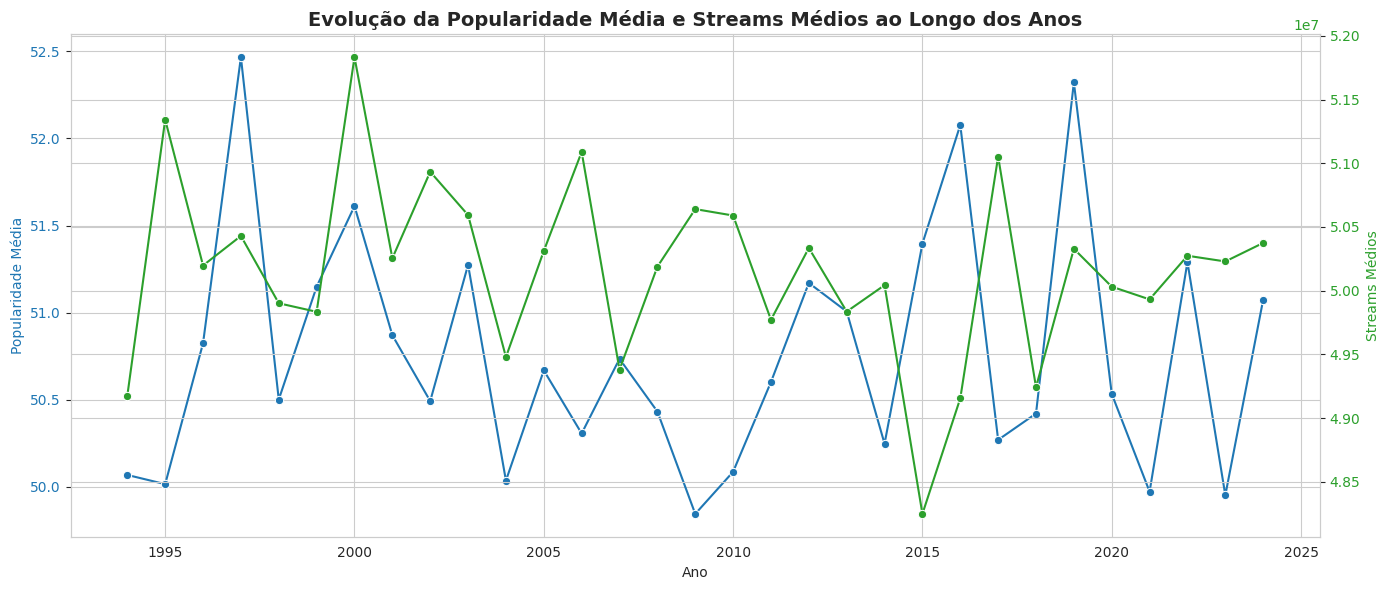

In [27]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year

year_stats = df.groupby('year').agg({
    'popularity': 'mean',
    'stream': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Popularidade Média', color=color)
sns.lineplot(data=year_stats, x='year', y='popularity', marker='o', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Streams Médios', color=color)
sns.lineplot(data=year_stats, x='year', y='stream', marker='o', ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolução da Popularidade Média e Streams Médios ao Longo dos Anos', fontsize=14, weight='bold')
fig.tight_layout()
plt.show()


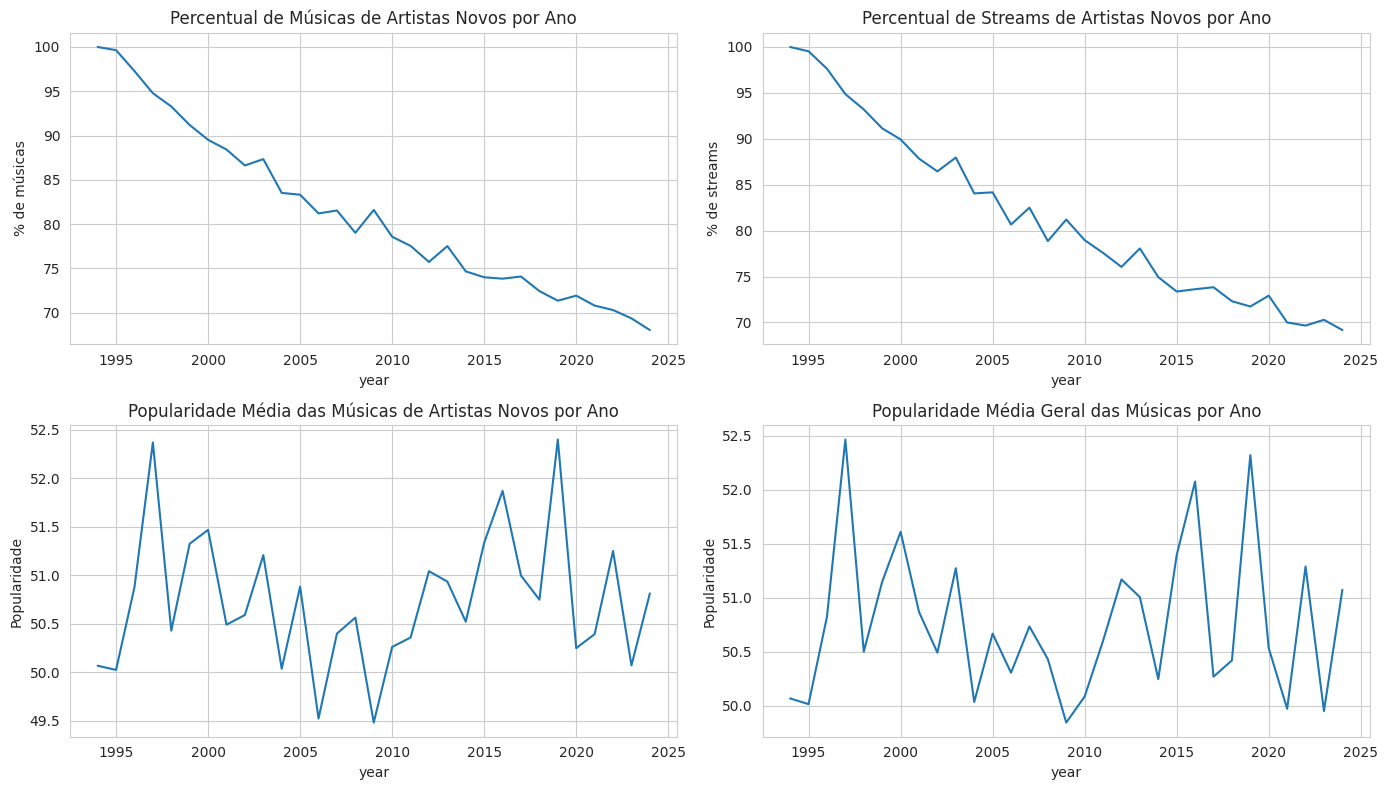

In [28]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year

first_appearance = df.groupby('artist')['year'].min().reset_index()
first_appearance.columns = ['artist', 'first_year']

df = df.merge(first_appearance, on='artist')

df['is_new_artist'] = df['year'] == df['first_year']

yearly_stats = df.groupby('year').agg(
    total_songs=('song_id', 'count'),
    new_artist_songs=('is_new_artist', 'sum'),
    total_streams=('stream', 'sum'),
    new_artist_streams=('stream', lambda x: x[df.loc[x.index, 'is_new_artist']].sum()),
    avg_popularity=('popularity', 'mean'),
    new_artist_avg_popularity=('popularity', lambda x: x[df.loc[x.index, 'is_new_artist']].mean())
).reset_index()

yearly_stats['pct_new_artist_songs'] = yearly_stats['new_artist_songs'] / yearly_stats['total_songs'] * 100
yearly_stats['pct_new_artist_streams'] = yearly_stats['new_artist_streams'] / yearly_stats['total_streams'] * 100

plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_songs')
plt.title('Percentual de Músicas de Artistas Novos por Ano')
plt.ylabel('% de músicas')

plt.subplot(2,2,2)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_streams')
plt.title('Percentual de Streams de Artistas Novos por Ano')
plt.ylabel('% de streams')

plt.subplot(2,2,3)
sns.lineplot(data=yearly_stats, x='year', y='new_artist_avg_popularity')
plt.title('Popularidade Média das Músicas de Artistas Novos por Ano')
plt.ylabel('Popularidade')

plt.subplot(2,2,4)
sns.lineplot(data=yearly_stats, x='year', y='avg_popularity')
plt.title('Popularidade Média Geral das Músicas por Ano')
plt.ylabel('Popularidade')

plt.tight_layout()
plt.show()


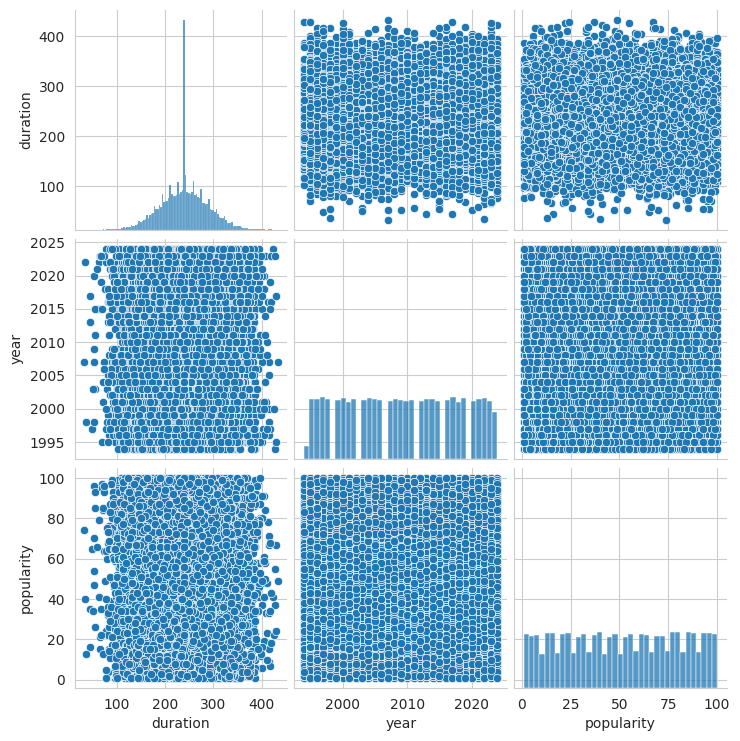

,duration,year,popularity
duration,1.000000,0.000991,0.000217
year,0.000991,1.000000,-0.000792
popularity,0.000217,-0.000792,1.000000


In [38]:
sns.pairplot(df[['duration', 'year', 'popularity']])
plt.show()

df[['duration', 'year', 'popularity']].corr()

In [33]:
from sklearn.linear_model import LinearRegression

features = ['genre', 'duration', 'language', 'explicit_content', 'label', 'composer', 'producer', 'year']
target = 'popularity'

X = df[features]
y = df[target]

categorical_cols = ['genre', 'language', 'explicit_content', 'label', 'composer', 'producer']
numerical_cols = ['duration', 'year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R² Score: {r2:.2f}')

model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print(f"Linear Regression R²: {r2_score(y_test, y_pred_lr):.2f}")

Linear Regression R²: -0.24


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# -------- 1. Feature Engineering básica --------
df['year'] = pd.to_datetime(df['release_date']).dt.year
df['popularity_class'] = pd.cut(df['popularity'], bins=[-1,30,60,100], labels=['Baixa','Média','Alta'])

# Reduzir cardinalidade de colunas categóricas
def reduce_categories(col, top_n=10):
    top = df[col].value_counts().nlargest(top_n).index
    return df[col].where(df[col].isin(top), other='Outros')

for col in ['label', 'composer', 'producer']:
    df[col] = reduce_categories(col, top_n=10)

# -------- 2. Separar features e target --------
features = ['genre', 'duration', 'language', 'explicit_content', 'label', 'composer', 'producer', 'year']
target = 'popularity_class'

X = df[features]
y = df[target]

# Separar tipos
categorical_cols = ['genre', 'language', 'explicit_content', 'label', 'composer', 'producer']
numerical_cols = ['duration', 'year']

# -------- 3. Pré-processamento --------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# -------- 4. Codificar o target com LabelEncoder --------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -------- 5. Dividir em treino e teste --------
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Transformar treino antes do SMOTE
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# -------- 6. Balancear com SMOTE --------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

# -------- 7. Treinar com XGBoost --------
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_resampled, y_resampled)

# -------- 8. Avaliação --------
y_pred = model.predict(X_test_transformed)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(y_test_labels, y_pred_labels))




              precision    recall  f1-score   support

        Alta       0.41      0.53      0.46      4052
       Baixa       0.30      0.24      0.27      2975
       Média       0.32      0.24      0.28      2973

    accuracy                           0.36     10000
   macro avg       0.34      0.34      0.33     10000
weighted avg       0.35      0.36      0.35     10000



In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)
print(grid_search.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


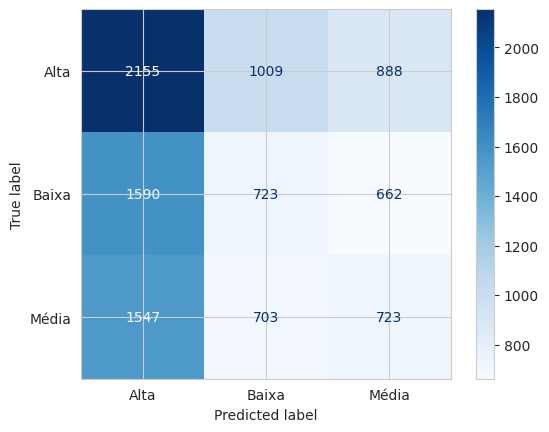

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Supondo que você já tenha:
# y_test_labels (verdadeiros)
# y_pred_labels (preditos)
# le.classes_ (lista com as classes na ordem)

# 1. Acurácia geral
acc = accuracy_score(y_test_labels, y_pred_labels)
print(f"Acurácia: {acc:.4f}\n")

# 2. Relatório completo com precision, recall e f1-score por classe
report = classification_report(y_test_labels, y_pred_labels, target_names=le.classes_)
print("Relatório de Classificação:")
print(report)

# 3. Matriz de confusão (numérica e porcentual)
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

print("Matriz de Confusão (contagem):")
print(df_cm)

# Matriz normalizada (proporções por linha, para entender erros relativos)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]
df_cm_norm = pd.DataFrame(cm_normalized, index=le.classes_, columns=le.classes_)

print("\nMatriz de Confusão (normalizada por classe):")
print(df_cm_norm)


Acurácia: 0.3601

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.41      0.53      0.46      4052
       Baixa       0.30      0.24      0.27      2975
       Média       0.32      0.24      0.28      2973

    accuracy                           0.36     10000
   macro avg       0.34      0.34      0.33     10000
weighted avg       0.35      0.36      0.35     10000

Matriz de Confusão (contagem):
       Alta  Baixa  Média
Alta   2155   1009    888
Baixa  1590    723    662
Média  1547    703    723

Matriz de Confusão (normalizada por classe):
           Alta     Baixa     Média
Alta   0.531836  0.249013  0.219151
Baixa  0.534454  0.243025  0.222521
Média  0.520350  0.236461  0.243189
